# Data Manipulation Methods and Exploratory Data Analysis

Having a good BS meter for data is crucial to becoming a good data scientist.  Data tells a story, and the way you tell the story, the context you provide, and most importantly, the details you leave out can change the message the story conveys.  When in doubt, it is best to conduct an exhaustive analysis of the data you have.  In particular, to understand data fully, one often needs to conduct exploratory data analysis (EDA).  If a scientist has conducted thorough EDA on their data, the reliability and trust of their work increases as they qualify their results and communicate truth more than results that support their hypothesis.

Although scientists can manipulate data in different ways, we will explore two ways with the following datasets: Berkeley admission data and health data.

# Berkeley Admissions Data

In this notebook, we will analyze graduate admissions data from UC Berkeley. To study this, we first import all relevant libraries, then we will consider if there seems to be unfair play with the admissions.  Let us begin with proper import statements.

In [2]:
# import statements
import os # operating system
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyreadstat
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

In [3]:
# Load the Berkeley admission data
file_path = 'berkeley.csv'
berkeley_data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
berkeley_data.head()

,Year,Major,Gender,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected


# Dataset description

The dataset contains the following columns:
- Year: The year of admission.
- Major: The department or field of study.
- Gender: The gender of the applicant.
- Admission: Whether the applicant was "Accepted" or "Rejected".

Let us calculate the overall admission rates for men and women.

In [4]:
# Calculate the overall admission rates by gender
### YOUR CODE HERE ###
overall_admission = berkeley_data.groupby(["Gender", "Admission"]).size().unstack(fill_value=0)

# Display overall admission rates
overall_admission["Total"] = overall_admission.sum(axis=1)
overall_admission

Admission,Accepted,Rejected,Total
Gender,,,
F,1494,2827,4321
M,3738,4704,8442


What do you notice?  Which gender seems to be favored more?  Are there any confounding variable that may be giving this result?  Please do some exploratory data analysis that will either support or reject the results from the previous analysis.

In [12]:
# Run some exploratory data analysis that supports or rejects the results from before (hint: consider confounding variables)
department_data = berkeley_data.groupby(['Major', 'Gender', 'Admission']).size().unstack(fill_value=0)
department_data['Total'] = department_data.sum(axis=1)
department_data['Admission Rate'] = department_data['Accepted'] / department_data['Total'] * 100

# Display the results in a pandas dataframe
department_data

Admission     Accepted  Rejected  Total  Admission Rate
Major Gender                                           
A     F             89        19    108       82.407407
      M            825       313   1138       72.495606
B     F             17         8     25       68.000000
      M            353       207    560       63.035714
C     F            201       392    593       33.895447
      M            120       205    325       36.923077
D     F            131       244    375       34.933333
      M            138       279    417       33.093525
E     F             94       299    393       23.918575
      M             53       138    191       27.748691
F     F             25       316    341        7.331378
      M             22       351    373        5.898123
Other F            937      1549   2486       37.691070
      M           2227      3211   5438       40.952556

What are the conclusions after the deeper analysis you conducted?  How did you fix the issue?  Can you abstract away the issue you saw to a general setting and methods to fix this issue in general?

In addition, create a plot/visual that shows your findings visually so that it is easier to conclude.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'A'),
  Text(1, 0, 'B'),
  Text(2, 0, 'C'),
  Text(3, 0, 'D'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F'),
  Text(6, 0, 'Other')])

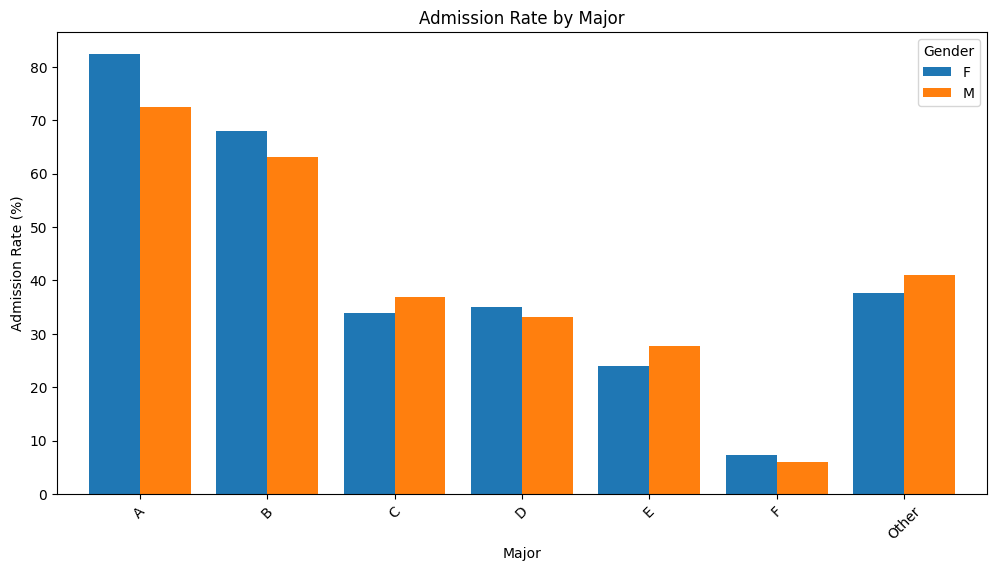

In [ ]:
# Create plot here...
department_data.reset_index(inplace=True)
pivot_data = department_data.pivot(index="Major", columns='Gender', values='Admission Rate')
pivot_data.plot(kind='bar', stacked=False, figsize=(12, 6), width=0.8)
plt.title('Admission Rate by Major')
plt.ylabel('Admission Rate (%)')
plt.xticks(rotation=45)

Discuss with your neighbors how you can better detect this particular method of data manipulation.  What questions can you ask to better detect this type of data manipulation?

# P-Hacking

P-hacking refers to the manipulation of data analysis to achieve statistically significant results, often leading to misleading conclusions. This practice undermines the integrity of scientific research by capitalizing on random chance rather than genuine effects.  One can achieve this by:

1. **Running Multiple Statistical Tests:**  Conducting numerous statistical analyses on the same dataset and selectively reporting those that yield significant results. For example, one can test 20 different variables against an outcome and only publishing the one with a p-value below 0.05, ignoring the increased likelihood of false positives.

2. **Selective Reporting of Variables:**  Measuring multiple outcomes but only reporting those that are statistically significant.  For example, in a clinical trial, assessing various health indicators but only publishing the significant improvement in blood pressure, omitting non-significant results for cholesterol and heart rate.

3. **Excluding Outliers Strategically:**  Removing data points that do not support the desired outcome without a valid justification. For example, discarding participants from a study whose responses counter the hypothesized effect, thereby artificially increasing significance.

4. **Combining or Splitting Groups:** Altering the grouping of data to achieve significant differences. For example, merging categories or dividing a continuous variable at different points until a significant difference between groups is found.

5. **Using Subgroup Analyses:** Conducting multiple analyses on various subgroups and reporting only those with significant findings. For example, analyzing the effect of a drug separately in different age groups and only reporting the age group where the effect was significant.

Engaging in p-hacking can lead to false discoveries (i.e. increased likelihood of Type I errors (false positives)) and non-reproducible results.

What are other methods of p-hacking that you can think of?

## NHANES

We will consider the National Health and Nutrition Examination Survey (NHANES) dataset to create a false relationship between caffeine intake and LDL cholesterol (the bad cholesterol).  We do this in steps.

1. Load the data.
2. Combine data from different files into one pandas dataframe.
3. Look at the overall correlation between caffeine intake and LDL cholesterol.
4. Manufacture a false correlation by subsampling and running many random samples until we get our result.

In [16]:
# set file paths
base_path = 'NHANES_DSET'
demographic_file = os.path.join(base_path, 'DEMO_I.xpt')
dietary_file = os.path.join(base_path, 'DR1TOT_I.xpt')
ldl_file = os.path.join(base_path, 'TRIGLY_I.xpt')
tot_chol_file = os.path.join(base_path, 'TCHOL_I.xpt')

# load data files
demographic_data, meta = pyreadstat.read_xport(demographic_file)
dietary_data, _ = pyreadstat.read_xport(dietary_file)
ldl_data, _ = pyreadstat.read_xport(ldl_file)
chol_data, _ = pyreadstat.read_xport(tot_chol_file)

In [19]:
ldl_data

,SEQN,WTSAF2YR,LBXTR,LBDTRSI,LBDLDL,LBDLDLSI
0,83733.0,54722.343330,147.0,1.660,173.0,4.474
1,83734.0,25471.093699,269.0,3.037,145.0,3.750
2,83736.0,38179.510870,47.0,0.531,142.0,3.672
3,83737.0,25800.845631,46.0,0.519,103.0,2.664
4,83741.0,108751.289086,68.0,0.768,102.0,2.638
...,...,...,...,...,...,...
3186,93687.0,54149.755608,50.0,0.565,94.0,2.431
3187,93689.0,23526.068487,64.0,0.723,73.0,1.888
3188,93695.0,136952.241981,78.0,0.881,56.0,1.448
3189,93696.0,0.000000,NaN,NaN,NaN,NaN


In [20]:
# Preview the data
print(demographic_data.head())

      SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  83732.0       9.0       2.0       1.0      62.0       NaN       3.0   
1  83733.0       9.0       2.0       1.0      53.0       NaN       3.0   
2  83734.0       9.0       2.0       1.0      78.0       NaN       3.0   
3  83735.0       9.0       2.0       2.0      56.0       NaN       3.0   
4  83736.0       9.0       2.0       2.0      42.0       NaN       4.0   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  DMDHREDU  DMDHRMAR  DMDHSEDU  \
0       3.0       1.0       NaN  ...       5.0       1.0       3.0   
1       3.0       1.0       NaN  ...       3.0       3.0       NaN   
2       3.0       2.0       NaN  ...       3.0       1.0       3.0   
3       3.0       2.0       NaN  ...       5.0       6.0       NaN   
4       4.0       2.0       NaN  ...       4.0       3.0       NaN   

        WTINT2YR       WTMEC2YR  SDMVPSU  SDMVSTRA  INDHHIN2  INDFMIN2  \
0  134671.370419  135629.507405      1.0     125.0      10.0

Thankfully, all the loaded files have a column for identifying the subjects throughout the files.  This is the column Respondent sequence number (SEQN).  We will combine the data using this column.  Please look at [this webpage](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2015) to understand where the data is coming from and what the variables mean.  In addition, read about how the data was collected and the demographics of the study.

In [21]:
# combine data
combined_data = pd.merge(demographic_data, dietary_data, on="SEQN")
combined_data = pd.merge(combined_data, ldl_data, on="SEQN")
combined_data = pd.merge(combined_data, chol_data, on="SEQN")
# Drop columns with more than 50% missing values
combined_data = combined_data.loc[:, combined_data.isnull().mean() < 0.5]
# Impute remaining missing values with the column mean
combined_data.fillna(combined_data.mean(), inplace=True)
combined_data

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,...,DRD370T,DRD370U,DRD370V,WTSAF2YR,LBXTR,LBDTRSI,LBDLDL,LBDLDLSI,LBXTC,LBDTCSI
0,83733.0,9.0,2.0,1.0,53.0,3.0,3.0,1.0,2.000000,2.0,...,1.000000,2.000000,2.0,54722.343330,147.000000,1.660000,173.00000,4.474000,265.000000,6.850000
1,83734.0,9.0,2.0,1.0,78.0,3.0,3.0,2.0,1.000000,1.0,...,2.000000,1.000000,2.0,25471.093699,269.000000,3.037000,145.00000,3.750000,229.000000,5.920000
2,83736.0,9.0,2.0,2.0,42.0,4.0,4.0,2.0,2.000000,1.0,...,1.722163,1.922912,2.0,38179.510870,47.000000,0.531000,142.00000,3.672000,204.000000,5.280000
3,83737.0,9.0,2.0,2.0,72.0,1.0,1.0,1.0,2.000000,2.0,...,1.000000,2.000000,2.0,25800.845631,46.000000,0.519000,103.00000,2.664000,190.000000,4.910000
4,83741.0,9.0,2.0,1.0,22.0,4.0,4.0,1.0,2.000000,1.0,...,2.000000,2.000000,2.0,108751.289086,68.000000,0.768000,102.00000,2.638000,164.000000,4.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,93687.0,9.0,2.0,2.0,16.0,2.0,2.0,2.0,1.910389,1.0,...,1.722163,1.922912,2.0,54149.755608,50.000000,0.565000,94.00000,2.431000,166.000000,4.290000
3187,93689.0,9.0,2.0,2.0,69.0,1.0,1.0,1.0,2.000000,1.0,...,2.000000,1.000000,2.0,23526.068487,64.000000,0.723000,73.00000,1.888000,167.000000,4.320000
3188,93695.0,9.0,2.0,2.0,76.0,3.0,3.0,2.0,2.000000,1.0,...,2.000000,2.000000,2.0,136952.241981,78.000000,0.881000,56.00000,1.448000,140.000000,3.620000
3189,93696.0,9.0,2.0,1.0,26.0,3.0,3.0,1.0,2.000000,1.0,...,1.722163,1.922912,2.0,0.000000,106.603746,1.203566,107.71508,2.785526,184.235693,4.764368


Let us find the true correlation between the caffeine variable and LDL variable.  Note that uncorrelated variables have correlation 0 whilst highly correlated variables have correlation close to 1 (past 0.7) and highly anti-correlated variables have correlation close to -1 (lower than -0.7).  The true correlation and associated p-value are shown here:

In [22]:
# define variables
caffeine_variable = 'DR1TCAFF'  # Dietary Caffeine Intake
ldl_variable = 'LBDLDL'         # LDL Cholesterol

# restrict to subset of only relevant variables
subset_data = combined_data[[caffeine_variable, ldl_variable]].dropna()
# pearsonr finds correlation and p-value associated with correlation
corr, p_value = pearsonr(subset_data[caffeine_variable], subset_data[ldl_variable])

print(f"True Correlation: {corr:.2f} | True p-value: {p_value:.10f}")

True Correlation: 0.13 | True p-value: 0.0000000000


We want to show that caffeine and LDL cholesterol is highly correlated.  To do this, we can restrict the data to a "good" set that finds high correlation with a good p-value.  We do this in the following cell:

In [23]:
# Initialize tracking variables
best_correlation = 0  # Start with a neutral value
best_p_value = 1.0
best_sample = None
sample_size = 50

# Run 1000000 random subsets for p-hacking
np.random.seed(42)  # For reproducibility
attempts = 1000000

# set variables for correlation study
caffeine_variable = 'DR1TCAFF'  # Dietary Caffeine Intake
ldl_variable = 'LBDLDL'         # LDL Cholesterol
# restrict to subset of relevant variables
subset_data = combined_data[[caffeine_variable, ldl_variable]].dropna()

# Run the reduced number of attempts with the fix
for i in range(attempts):
    # Randomly sample a subset of the data (e.g., 50 data points)
    sample = subset_data.sample(sample_size, replace=False)
    corr, p_value = pearsonr(sample[caffeine_variable], sample[ldl_variable])

    # Track the best correlation with statistical significance
    if p_value < 0.05 and abs(corr) > abs(best_correlation):
        best_correlation = corr
        best_p_value = p_value
        best_sample = sample

    # Print progress every 10,000 attempts
    if (i + 1) % 10000 == 0:
        print(f"Attempts so far: {i + 1} | Best Correlation: {best_correlation:.2f}, p-value: {best_p_value:.10f}")

# Display the best result found
if best_sample is not None:
    print(f"\nBest Correlation Found After {attempts} Attempts:")
    print(f"Correlation: {best_correlation:.2f}, p-value: {best_p_value:.10f}")
else:
    print(f"No statistically significant result found after {attempts} attempts.")


Attempts so far: 10000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 20000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 30000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 40000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 50000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 60000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 70000 | Best Correlation: 0.68, p-value: 0.0000000429
Attempts so far: 80000 | Best Correlation: 0.71, p-value: 0.0000000059
Attempts so far: 90000 | Best Correlation: 0.71, p-value: 0.0000000059
Attempts so far: 100000 | Best Correlation: 0.71, p-value: 0.0000000059
Attempts so far: 110000 | Best Correlation: 0.71, p-value: 0.0000000059
Attempts so far: 120000 | Best Correlation: 0.71, p-value: 0.0000000059
Attempts so far: 130000 | Best Correlation: 0.71, p-value: 0.0000000059
Attempts so far: 140000 | Best Correlation: 0.71, p-value: 0.0000000059
A

What are questions one can ask about the data which can help detect p-hacking in a study?  What are aspects that can confound a result?  Here, we maliciously manipulate results to show a particular result, but generally, p-hacking may occur even when a researcher is not trying to p-hack.  What are practices that will combat p-hacking?  What characteristics should a researcher embody to actively combat p-hacking in any studies or data analyses that they conduct?